In [1]:
using Revise
using TransportBasedInference
using HierarchicalDA
using LinearAlgebra
using OrdinaryDiffEq
using Trixi
using FFTW
using DifferentialEquations
using Distributions
using Statistics
using SparseArrays
using LinearMaps

In [2]:
using CairoMakie
using LaTeXStrings
# using Plots

In [3]:
polydeg = 3
Ncells = 100

Nx = (polydeg+1)*Ncells
Δ = 20
Ny = ceil(Int64, Nx/Δ)

# Define Trixi system for inviscid Burgers equation
sys_burgers = setup_burgers(polydeg, Ncells);

xgrid = vec(sys_burgers.mesh.md.xq);

Define polynomial annihilator operator

In [4]:
order_PA = 3

Ns = Nx - 2*ceil(Int64, order_PA/2)

PA = PolyAnnil(xgrid, order_PA; istruncated = true)

@assert size(PA.P) == (Ns, Nx)

S = LinearMaps.FunctionMap{Float64,true}((s,x)->mul!(s, PA.P, x), (x,s)->mul!(x, PA.P', s),
Ns, Nx; issymmetric=false, isposdef=false)

xs = xgrid[ceil(Int64, order_PA/2)+1:end-ceil(Int64, order_PA/2)]

396-element Vector{Float64}:
 -0.9866001895641519
 -0.9813886368840595
 -0.9786113631159403
 -0.9733998104358488
 -0.9666001895641518
 -0.9613886368840595
 -0.9586113631159403
 -0.9533998104358486
 -0.9466001895641517
 -0.9413886368840595
 -0.9386113631159403
 -0.9333998104358486
 -0.9266001895641518
  ⋮
  0.9333998104358489
  0.9386113631159406
  0.9413886368840593
  0.9466001895641516
  0.9533998104358488
  0.9586113631159405
  0.9613886368840594
  0.9666001895641515
  0.973399810435849
  0.9786113631159405
  0.9813886368840595
  0.9866001895641516

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [5]:
Δtdyn = 0.01
Δtobs = 0.01

0.01

Define the time span of interest

In [6]:
t0 = 0.0
Tf = 200
Tspin = 100
tf = t0 + Tf*Δtobs

2.0

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [7]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 400
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]
)


In [8]:
σx_true = 1e-6#Δtobs*1.0
σx = 0.01#copy(σx_true)
@show σx


σy = 0.2

ϵx_true = AdditiveInflation(Nx, zeros(Nx), σx_true)
ϵx = AdditiveInflation(Nx, zeros(Nx), σx)

ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

σx = 0.01


AdditiveInflation(20, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.04000000000000001 0.0 … 0.0 0.0; 0.0 0.04000000000000001 … 0.0 0.0; … ; 0.0 0.0 … 0.04000000000000001 0.0; 0.0 0.0 … 0.0 0.04000000000000001], [0.2 0.0 … 0.0 0.0; 0.0 0.2 … 0.0 0.0; … ; 0.0 0.0 … 0.2 0.0; 0.0 0.0 … 0.0 0.2])

Setup system for inviscid Burgers equation

In [9]:
h(x, t) = x[1:Δ:end]
H = LinearMap(sparse(Matrix(1.0*I, Nx, Nx)[1:Δ:end,:]))
F = StateSpace(x->x, h)

StateSpace(var"#5#6"(), TransportBasedInference.var"#27#28"(), h)

Define ObsConstraintSystem

In [10]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx_true, ϵy, π0, 0, 0, 0, F);

In [11]:
# Define function class for the initial condition
αk = 0.7
f0 = SmoothPeriodic(xgrid, αk; L = 2.0)

SmoothPeriodic(400, 1, 2.0, 0.7, ComplexF64[0.2930876813060462 - 0.17856138224322707im, 0.08753367962760195 - 0.14530356570309924im, 0.6372107859711361 + 0.2973429658860433im, -0.6361894584954833 - 0.07199835525979192im, 0.19324064782748138 - 0.13037491631290377im, -0.02740282260862437 + 0.28667700412460717im, 0.1265107189311181 + 0.06184665513131545im, -0.08123475324295329 - 0.1238143773679981im, -0.1424953194566991 - 0.1609266773889738im, 0.010267828923929493 + 0.1335464433404424im  …  -2.00548343429991e-15 + 3.4651376898694673e-15im, 3.931113251767993e-15 + 8.254819981316332e-15im, -3.174792135709319e-15 + 9.088889770640946e-15im, 3.847276582799542e-15 + 2.6959741670786248e-15im, -5.315067247360861e-15 + 2.3351563793034667e-15im, -9.68581429006707e-15 + 4.878945189634266e-16im, 6.012697750750438e-16 + 2.8971716363500015e-15im, -6.394946510911497e-16 + 8.912808416096056e-15im, 1.031653872352685e-15 - 3.0809452417447262e-15im, -2.3981727673536667e-15 + 1.998288363102855e-15im])

In [12]:
x0 = vec(1/2 .+ 0.5*sin.(3*π*sys_burgers.mesh.md.xq));
# x0 = f0.(xgrid);

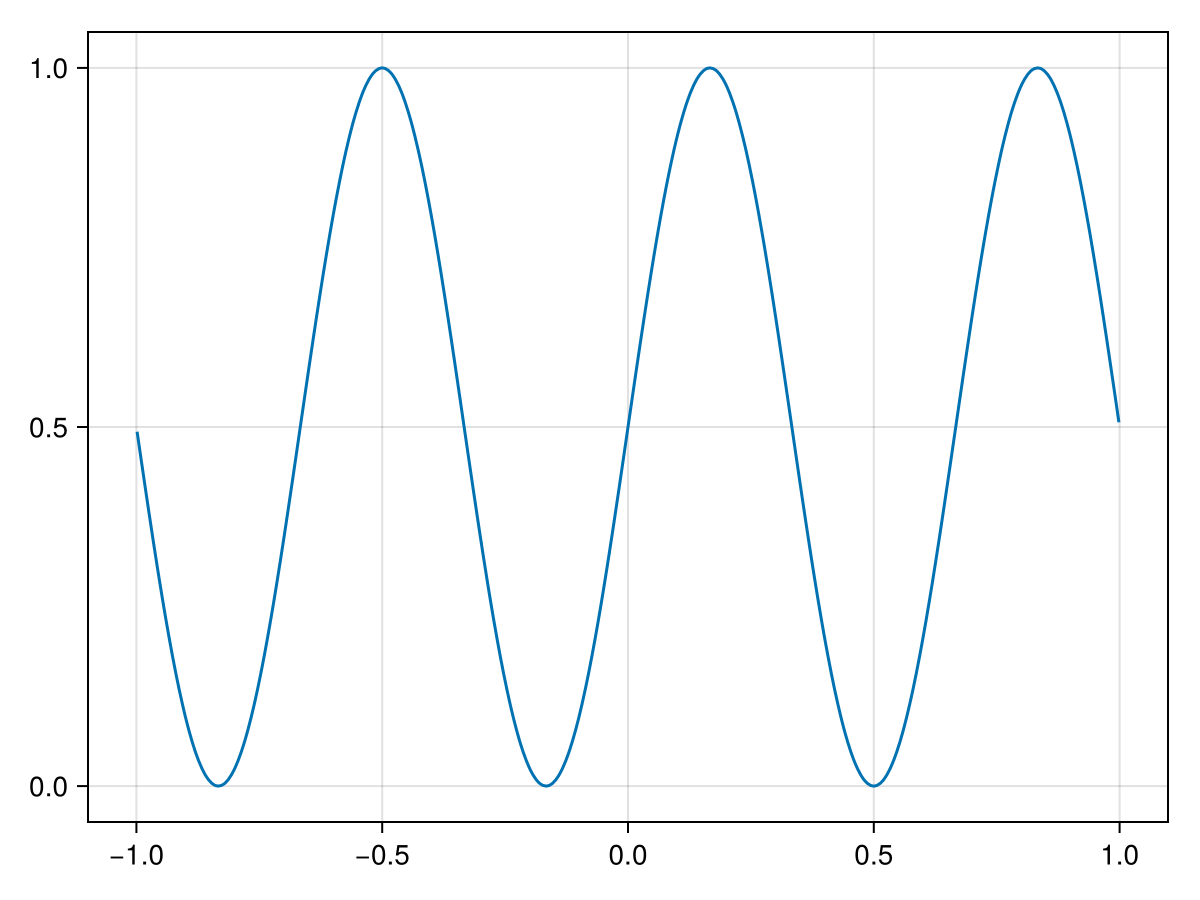

In [13]:
lines(xgrid, x0)

In [14]:
@time data = generate_data_trixi(model, x0, Tf, sys_burgers)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


 11.302907 seconds (38.50 M allocations: 2.343 GiB, 7.88% gc time, 98.27% compilation time)


SyntheticData([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1  …  1.9100000000000001, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.0], 0.01, [0.4934563896573869, 0.4689173941833885, 0.4370225997681946, 0.4127450715138443, 0.39988966148727423, 0.3759585049420274, 0.34519359951990536, 0.3220375820269989, 0.3098693919682456, 0.2873938475030665  …  0.7126061524969327, 0.6901306080317535, 0.677962417973001, 0.6548064004800963, 0.6240414950579708, 0.6001103385127249, 0.5872549284861557, 0.5629774002318063, 0.5310826058166097, 0.5065436103426122], [0.5178564901660694 0.5447381700474978 … 0.5029107499187904 0.5006367684899551; 0.4920860370836143 0.5176854429691752 … 0.5052746130739855 0.5029942182224074; … ; 0.5572367303273098 0.5858940923238382 … 0.4992771448092182 0.49701484649466543; 0.5315724059250588 0.5590996609820686 … 0.5016499162664699 0.49937504401200417], [0.6390897706444943 0.49268328092211305 … 0.5246462469100616 0.4572770589587325; 0.15431398705080418 -0.358609454

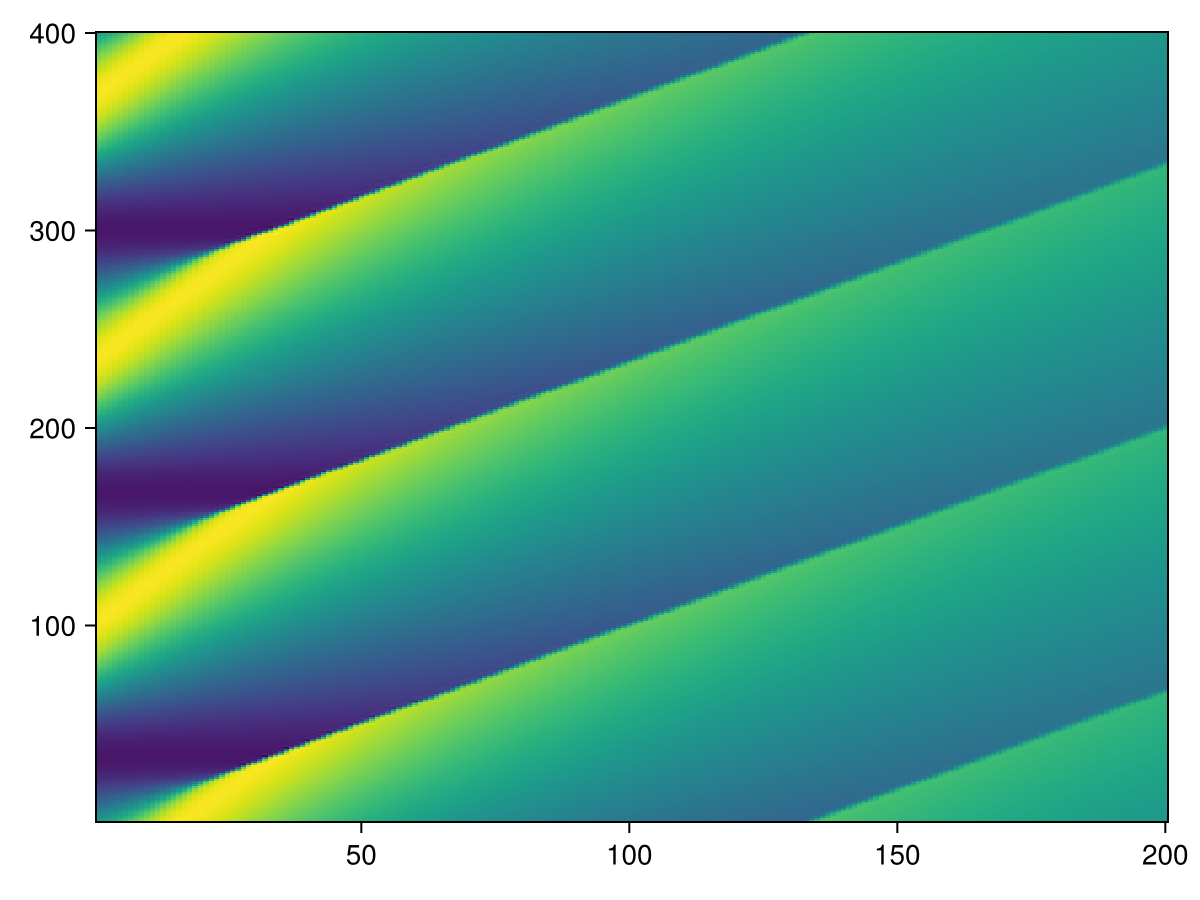

In [15]:
heatmap(data.xt[:, 1:end]')

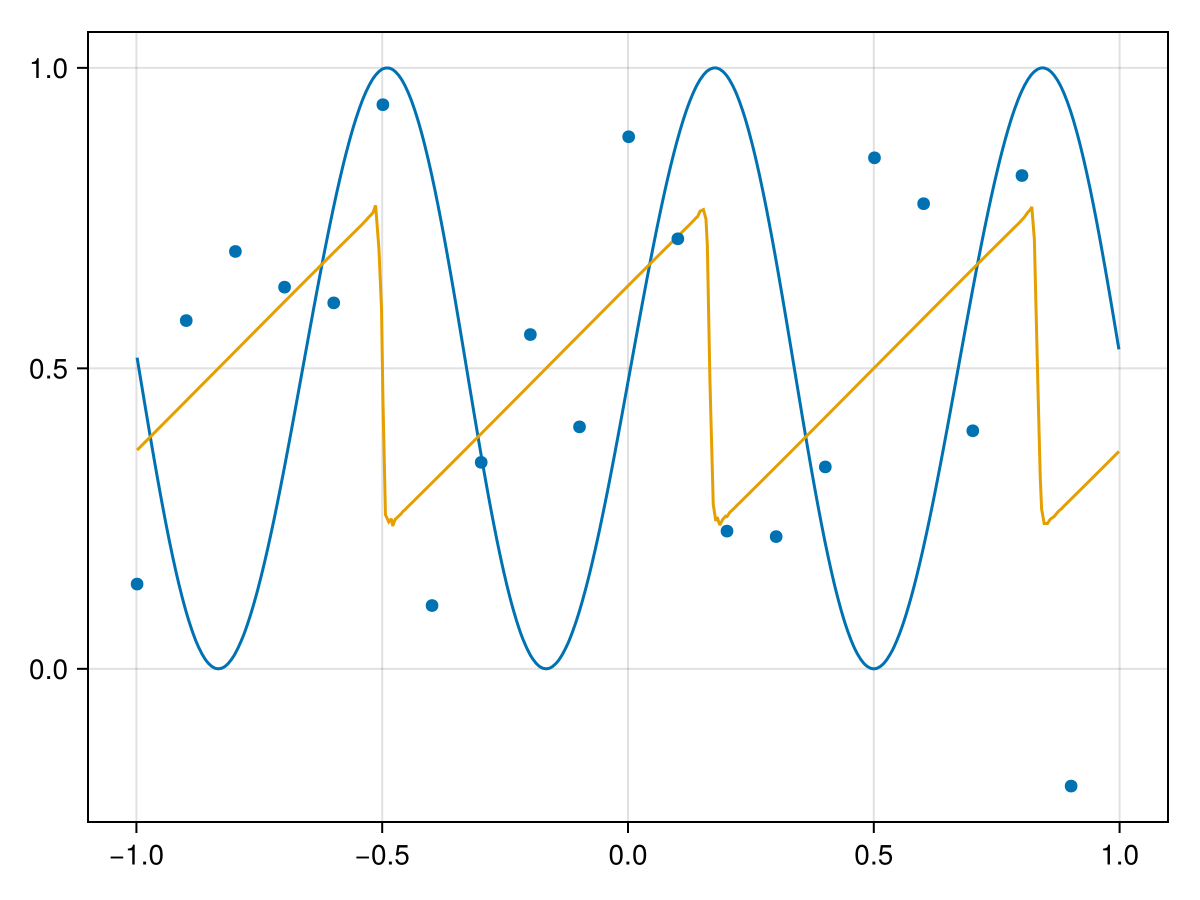

In [16]:
fig = Figure()
ax = Axis(fig[1,1])

lines!(ax, xgrid, data.xt[:,1])
lines!(ax, xgrid, data.xt[:,100])
scatter!(ax, xgrid[1:Δ:end], data.yt[:,100])

fig

In [17]:
norm(data.xt[:,1] .- mean(data.xt[:,1]))

7.07109497824551

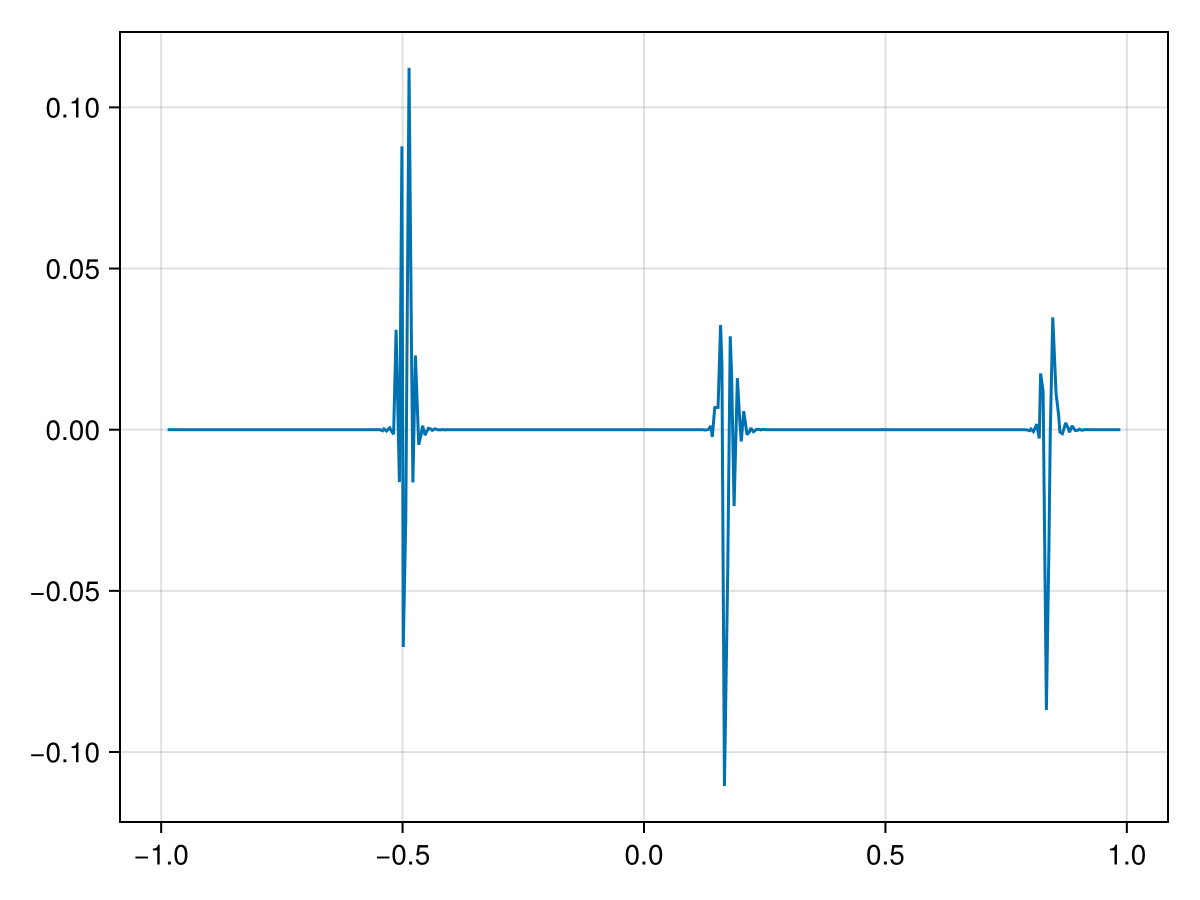

In [18]:
fig = Figure()
ax = Axis(fig[1,1])

# lines!(ax, xgrid, data.xt[:,1])
lines!(ax, xs, PA*data.xt[:,100])

fig

Define ObsConstraintSystem

In [19]:
idx = 4

## Selecion of hyper-prior parameters
# power parameter
r_range = [ 1.0, .5, -.5, -1.0 ]; 
r = r_range[idx] # select parameter 
# shape parameter
β_range = [ 1.501, 3.0918, 2.0165, 1.0017 ]; 
β = β_range[idx] # shape parameter
# rate parameters 
ϑ_range = [ 5*10^(-2), 5.9323*10^(-3), 1.2583*10^(-3), 1.2308*10^(-4) ]; 
ϑ = ϑ_range[idx]


# r = -0.5
# β = 0.5
# ϑ = 0.01
dist = GeneralizedGamma(r, β, ϑ);

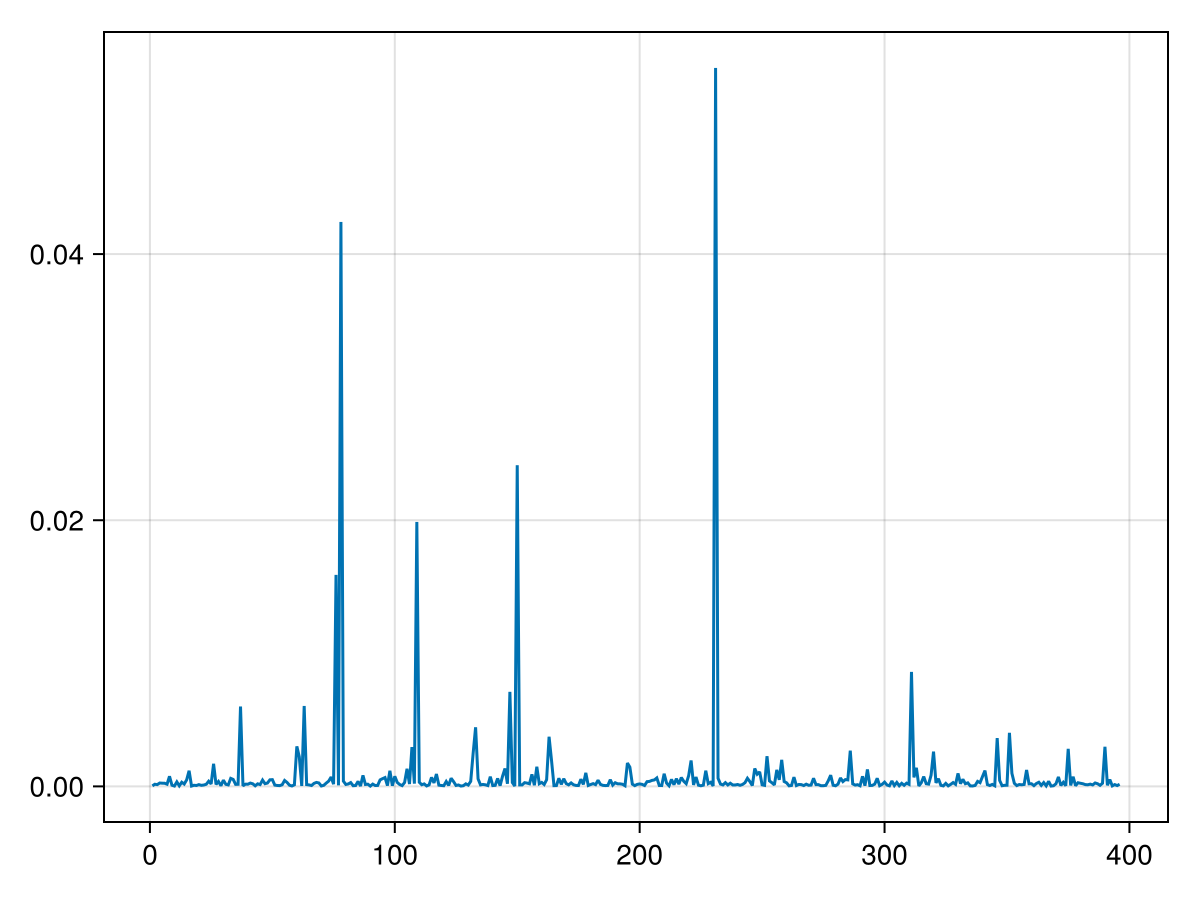

In [20]:
fig = Figure()

lines(rand(dist, Ns))

Create initial ensemble

In [21]:
Ne = 50
X = zeros(model.Ny + model.Nx, Ne)

for i=1:Ne
    regenerate!(f0)
    X[Ny+1:Ny+Nx,i] = f0.(xgrid)#initial_condition(αk, Δx, Nx)
end

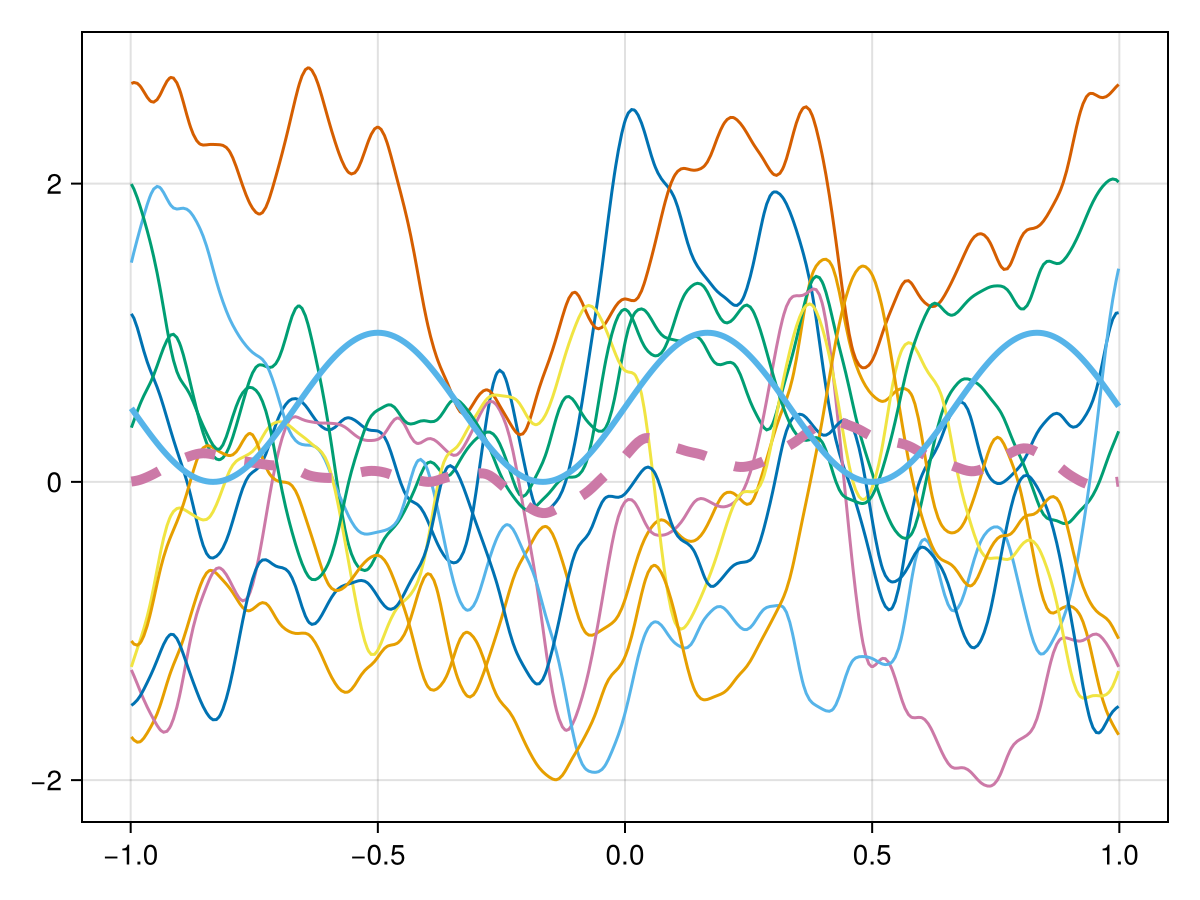

In [22]:
fig = Figure()

ax = Axis(fig[1,1])

for i=1:10
    lines!(ax, xgrid, X[Ny+1:Ny+Nx,i])
end
lines!(xgrid, mean(X[Ny+1:Ny+Nx,:]; dims = 2)[:,1], linewidth = 5, linestyle = :dash)

lines!(ax, xgrid, x0, linewidth = 3)

fig

Define initial guess

In [23]:
θinit = rand(dist, Ns);

Define linear maps and ObsConstraintSystem

In [24]:
Cθ = LinearMap(Diagonal(deepcopy(θinit)))
Cϵ = LinearMap(ϵy.Σ)
CX = LinearMap(Diagonal(1.0 .+ rand(Nx)))
sys_ys = ObsConstraintSystem(H, S, Cθ, Cϵ, CX)

ObsConstraintSystem(400, 20, 396, 20×400 LinearMaps.WrappedMap{Float64} of
  20×400 SparseMatrixCSC{Float64, Int64} with 20 stored entries, 396×400 LinearMaps.FunctionMap{Float64,true}(#1, #2; issymmetric=false, ishermitian=false, isposdef=false), 396×396 LinearMaps.WrappedMap{Float64} of
  396×396 Diagonal{Float64, Vector{Float64}}, 20×20 LinearMaps.WrappedMap{Float64} of
  20×20 Diagonal{Float64, Vector{Float64}}, LinearMap[400×400 LinearMaps.WrappedMap{Float64} of
  400×400 Diagonal{Float64, Vector{Float64}}])

In [25]:
sys_y = ObsSystem(H, Cϵ, CX)

ObsSystem(400, 20, 20×400 LinearMaps.WrappedMap{Float64} of
  20×400 SparseMatrixCSC{Float64, Int64} with 20 stored entries, 20×20 LinearMaps.WrappedMap{Float64} of
  20×20 Diagonal{Float64, Vector{Float64}}, LinearMap[400×400 LinearMaps.WrappedMap{Float64} of
  400×400 Diagonal{Float64, Vector{Float64}}])

In [26]:
yidx = 1:Δ:Nx
idx = vcat(collect(1:length(yidx))', collect(yidx)')

# @assert length(yidx) == Ny

# # Create Localization structure
Gxx(i,j) = periodicmetric!(i,j, Nx)
Gxy(i,j) = periodicmetric!(i,yidx[j], Nx)
Gyy(i,j) = periodicmetric!(yidx[i],yidx[j], Nx)

Lrad = 10
Loc = Localization(Lrad, Gxx, Gxy, Gxx)

Localization(10.0, Gxx, Gxy, Gxx)

In [27]:
β = 1.02
ϵxβ = MultiAddInflation(Nx, β, zeros(Nx), σx)

MultiAddInflation(400, 1.02, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0001 0.0 … 0.0 0.0; 0.0 0.0001 … 0.0 0.0; … ; 0.0 0.0 … 0.0001 0.0; 0.0 0.0 … 0.0 0.0001], [0.01 0.0 … 0.0 0.0; 0.0 0.01 … 0.0 0.0; … ; 0.0 0.0 … 0.01 0.0; 0.0 0.0 … 0.0 0.01])

Define EnKF

In [28]:
enkf = EnKF(Ne, ϵy, sys_y, Δtdyn, Δtobs)

Ensemble Kalman filter with 
iterative solver = false and 
filtered = false


Define localized EnKF

In [29]:
locenkf = LocEnKF(Ne, ϵy, sys_y, Loc, Δtdyn, Δtobs)

Localized ensemble Kalman filter with iterative = false and filtered = false


Define hierarchical EnKF

In [30]:
henkf = HEnKF(Ne, ϵy, sys_ys, dist, deepcopy(θinit), Δtdyn, Δtobs)

Hierarchical ensemble Kalman filter with
        iterative solver = false and
        filtered = false


Define hierarchical and localized EnKF

In [31]:
hlocenkf = HLocEnKF(Ne, ϵy, sys_ys, Loc, dist, deepcopy(θinit), Δtdyn, Δtobs)

Hierarchical localized ensemble Kalman filter with
        iterative solver = false and
        filtered = false


In [32]:
# X_enkf = seqassim_trixi(data, Tf, ϵxβ, enkf, deepcopy(X), model.Ny, model.Nx, t0, sys_burgers);

In [33]:
X_locenkf = seqassim_trixi(data, Tf, ϵxβ, locenkf, deepcopy(X), model.Ny, model.Nx, t0, sys_burgers);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


In [34]:
# X_henkf, θ_henkf = seqassim_trixi(data, Tf, ϵxβ, henkf, deepcopy(X), model.Ny, model.Nx, t0, sys_burgers);

In [35]:
X_hlocenkf, θ_hlocenkf = seqassim_trixi(data, Tf, ϵxβ, hlocenkf, deepcopy(X), model.Ny, model.Nx, t0, sys_burgers);

Progress: 100%|█████████████████████████████████████████| Time: 0:04:29


In [41]:
google_colors = [
    RGBf(0.2588, 0.5216, 0.9569),  # Blue: #4285F4
    RGBf(0.9176, 0.2627, 0.2078),  # Red: #EA4335
    RGBf(0.9843, 0.7373, 0.0196),  # Yellow: #FBBC05
    RGBf(0.2039, 0.6588, 0.3255),  # Green: #34A853
    RGBf(0.9843, 0.5490, 0.0000),  # Orange: #FB8C00
    RGBf(0.4157, 0.1059, 0.6039)   # Purple: #9C27B0
]

In [42]:
tsnap1*Δtobs

0.1

In [43]:
# # Define a function to create LaTeX-style text
# latextext(s) = L"\mathrm{" * s * "}"

# # Update the global theme to use LaTeX for all text elements
# CairoMakie.update_theme!(;
#     Axis = (;
#         title = latextext,
#         xlabel = latextext,
#         ylabel = latextext,
#         xticklabel = latextext,
#         yticklabel = latextext,
#     )
# )

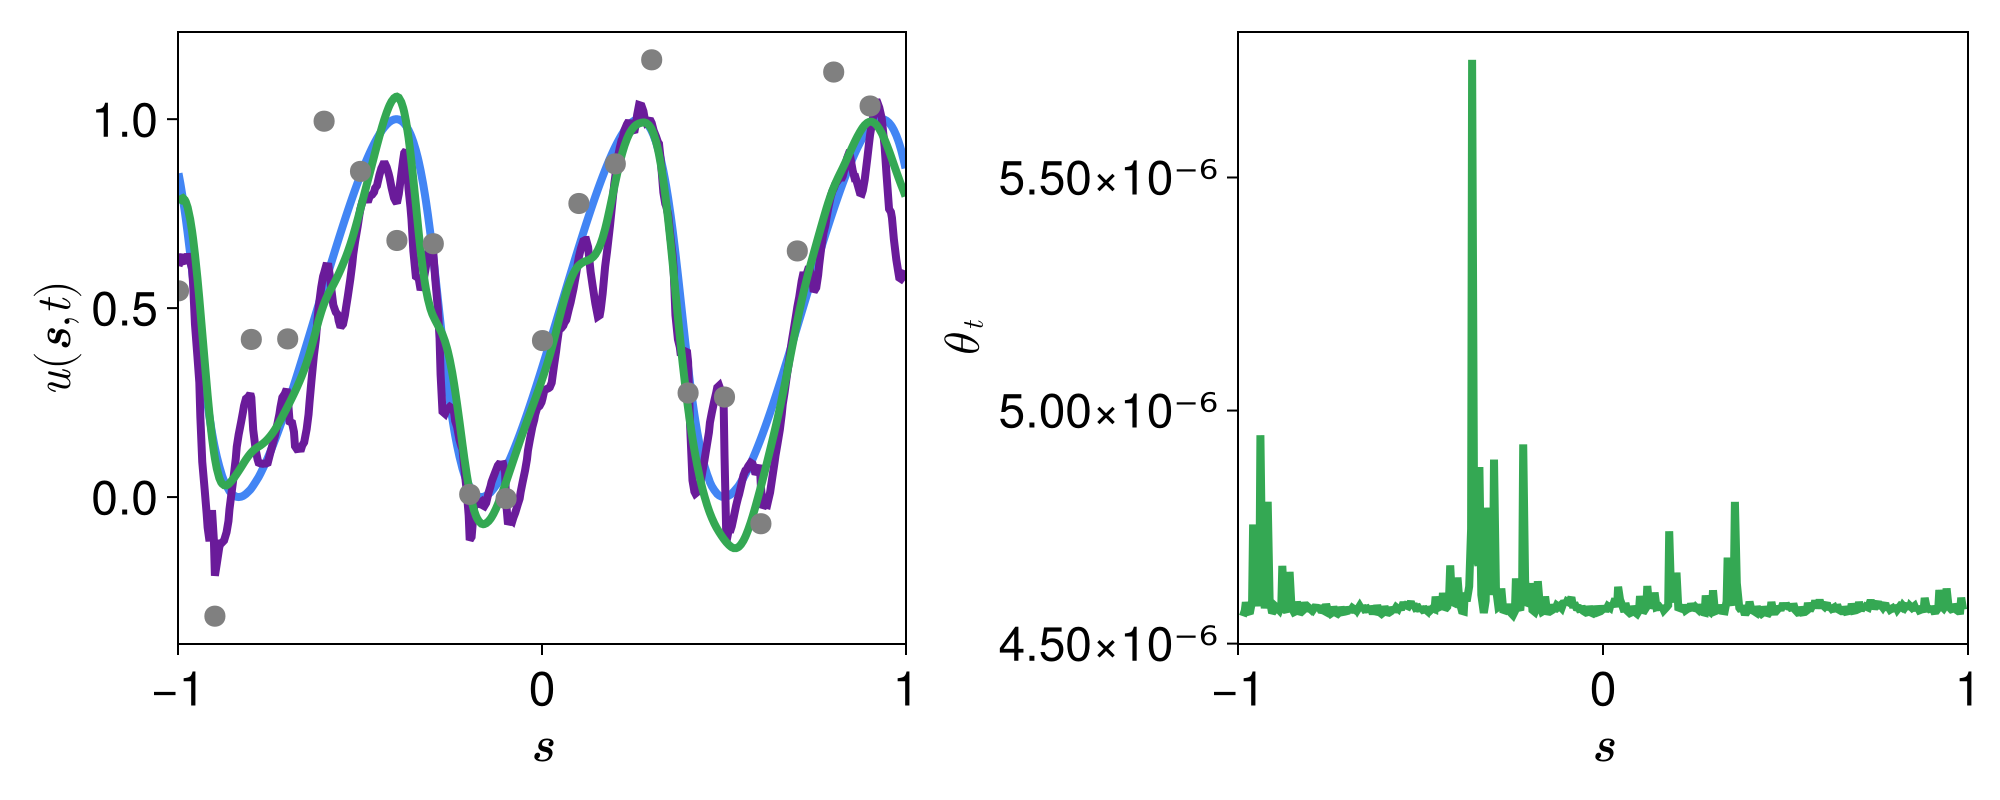

In [44]:
fig1 = Figure(fontsize = 24, size = (1000, 400))
    
ax11 = Axis(fig1[1,1], 
          xlabel = L"\mathbf{s}",
          ylabel = L"u(\mathbf{s}, t)",
          xticks = [-1.0; 0.0; 1.0],
          xgridvisible = false,
          ygridvisible = false)
#           xticklabelformatter = x -> string(round(x, digits=1)),
#           yticklabelformatter = y -> string(round(y, digits=1)))
#           ylabel = L"\boldsym" 

tsnap1 = 10

lines!(ax11, xgrid, data.xt[:,tsnap1], linewidth = 4, label = L"\text{Truth}", color = google_colors[1])
lines!(ax11, xgrid, mean(X_locenkf[tsnap1+1]; dims = 2)[:,1], linewidth = 4, color = google_colors[6],
label = L"\text{EnKF}")



lines!(ax11, xgrid, mean(X_hlocenkf[tsnap1+1]; dims = 2)[:,1], linewidth = 4, label = L"\text{Regularized EnKF}", 
       color = google_colors[4])

scatter!(ax11, xgrid[1:Δ:end], data.yt[:,tsnap1], 
        color = :grey, markersize = 15, label = L"\text{Observations}")


xlims!(ax11, -1, 1)

ax12 = Axis(fig1[1,2], 
          xlabel = L"\mathbf{s}",
          ylabel = L"\mathbf{\theta}_t",
          xticks = [-1.0; 0.0; 1.0],
        xgridvisible = false,
        ygridvisible = false,)
#           ylabel = L"\boldsym" 


lines!(ax12, xs, θ_hlocenkf[tsnap1], linewidth = 4, label = L"\mathbf{\theta}", color = google_colors[4])
xlims!(ax12, -1, 1)
# ylims!(ax2, 1e-6, 3e-6)

# Create a legend and place it in a separate layout cell
# legend = Legend(fig1[1, 3], ax11)

fig1

save("profile_burgers_01.pdf", fig1)

fig1

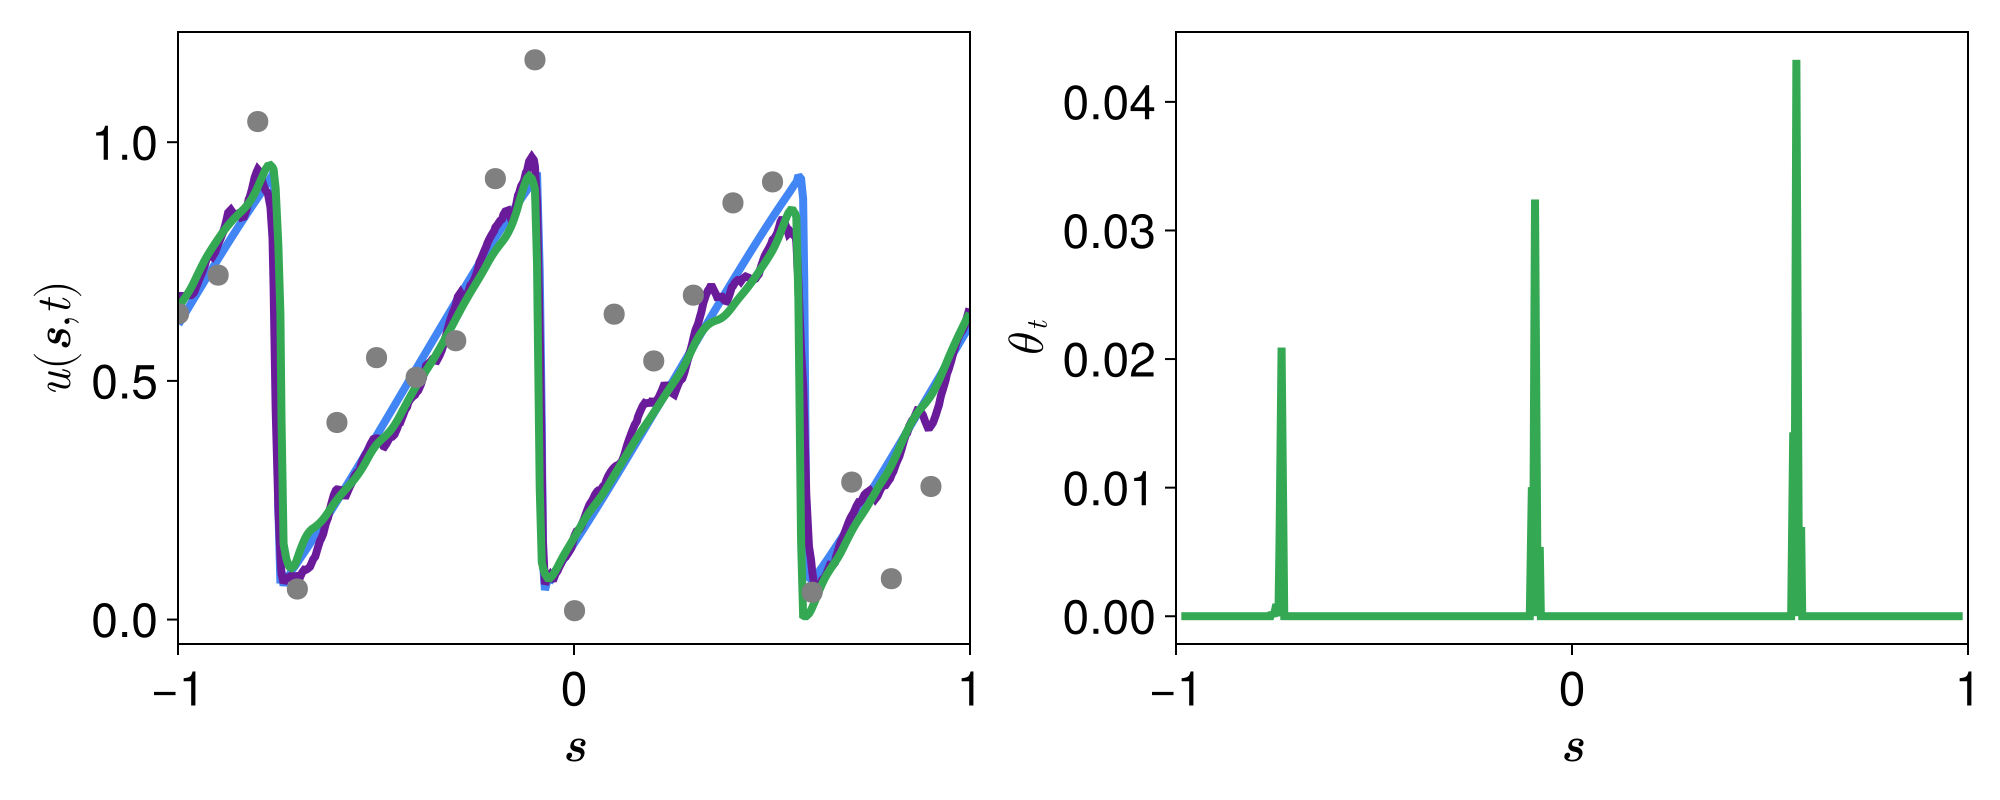

In [45]:
fig2 = Figure(fontsize = 24, size = (1000, 400))

    
ax21 = Axis(fig2[1,1], 
          xlabel = L"\mathbf{s}",
          ylabel = L"u(\mathbf{s}, t)",
          xticks = [-1.0; 0.0; 1.0],
        xgridvisible = false,
        ygridvisible = false,)
#           ylabel = L"\boldsym" 

tsnap2 = 50

lines!(ax21, xgrid, data.xt[:,tsnap2], linewidth = 4, label = L"\text{Truth}", color = google_colors[1])
lines!(ax21, xgrid, mean(X_locenkf[tsnap2+1]; dims = 2)[:,1], linewidth = 4, color = google_colors[6],
label = L"\text{EnKF}")



lines!(ax21, xgrid, mean(X_hlocenkf[tsnap2+1]; dims = 2)[:,1], linewidth = 4, label = L"\text{Regularized EnKF}", 
       color = google_colors[4])

scatter!(ax21, xgrid[1:Δ:end], data.yt[:,tsnap2], 
        color = :grey, markersize = 15, label = L"\text{Observations}")


xlims!(ax21, -1, 1)

ax22 = Axis(fig2[1,2], 
          xlabel = L"\mathbf{s}",
          ylabel = L"\mathbf{\theta}_t",
          xticks = [-1.0; 0.0; 1.0],
        xgridvisible = false,
        ygridvisible = false,)
#           ylabel = L"\boldsym" 

lines!(ax22, xs, θ_hlocenkf[tsnap2], linewidth = 4, label = L"\mathbf{\theta}", color = google_colors[4])
xlims!(ax22, -1, 1)
# ylims!(ax2, 1e-6, 3e-6)
fig2

save("profile_burgers_05.pdf", fig2)

fig2

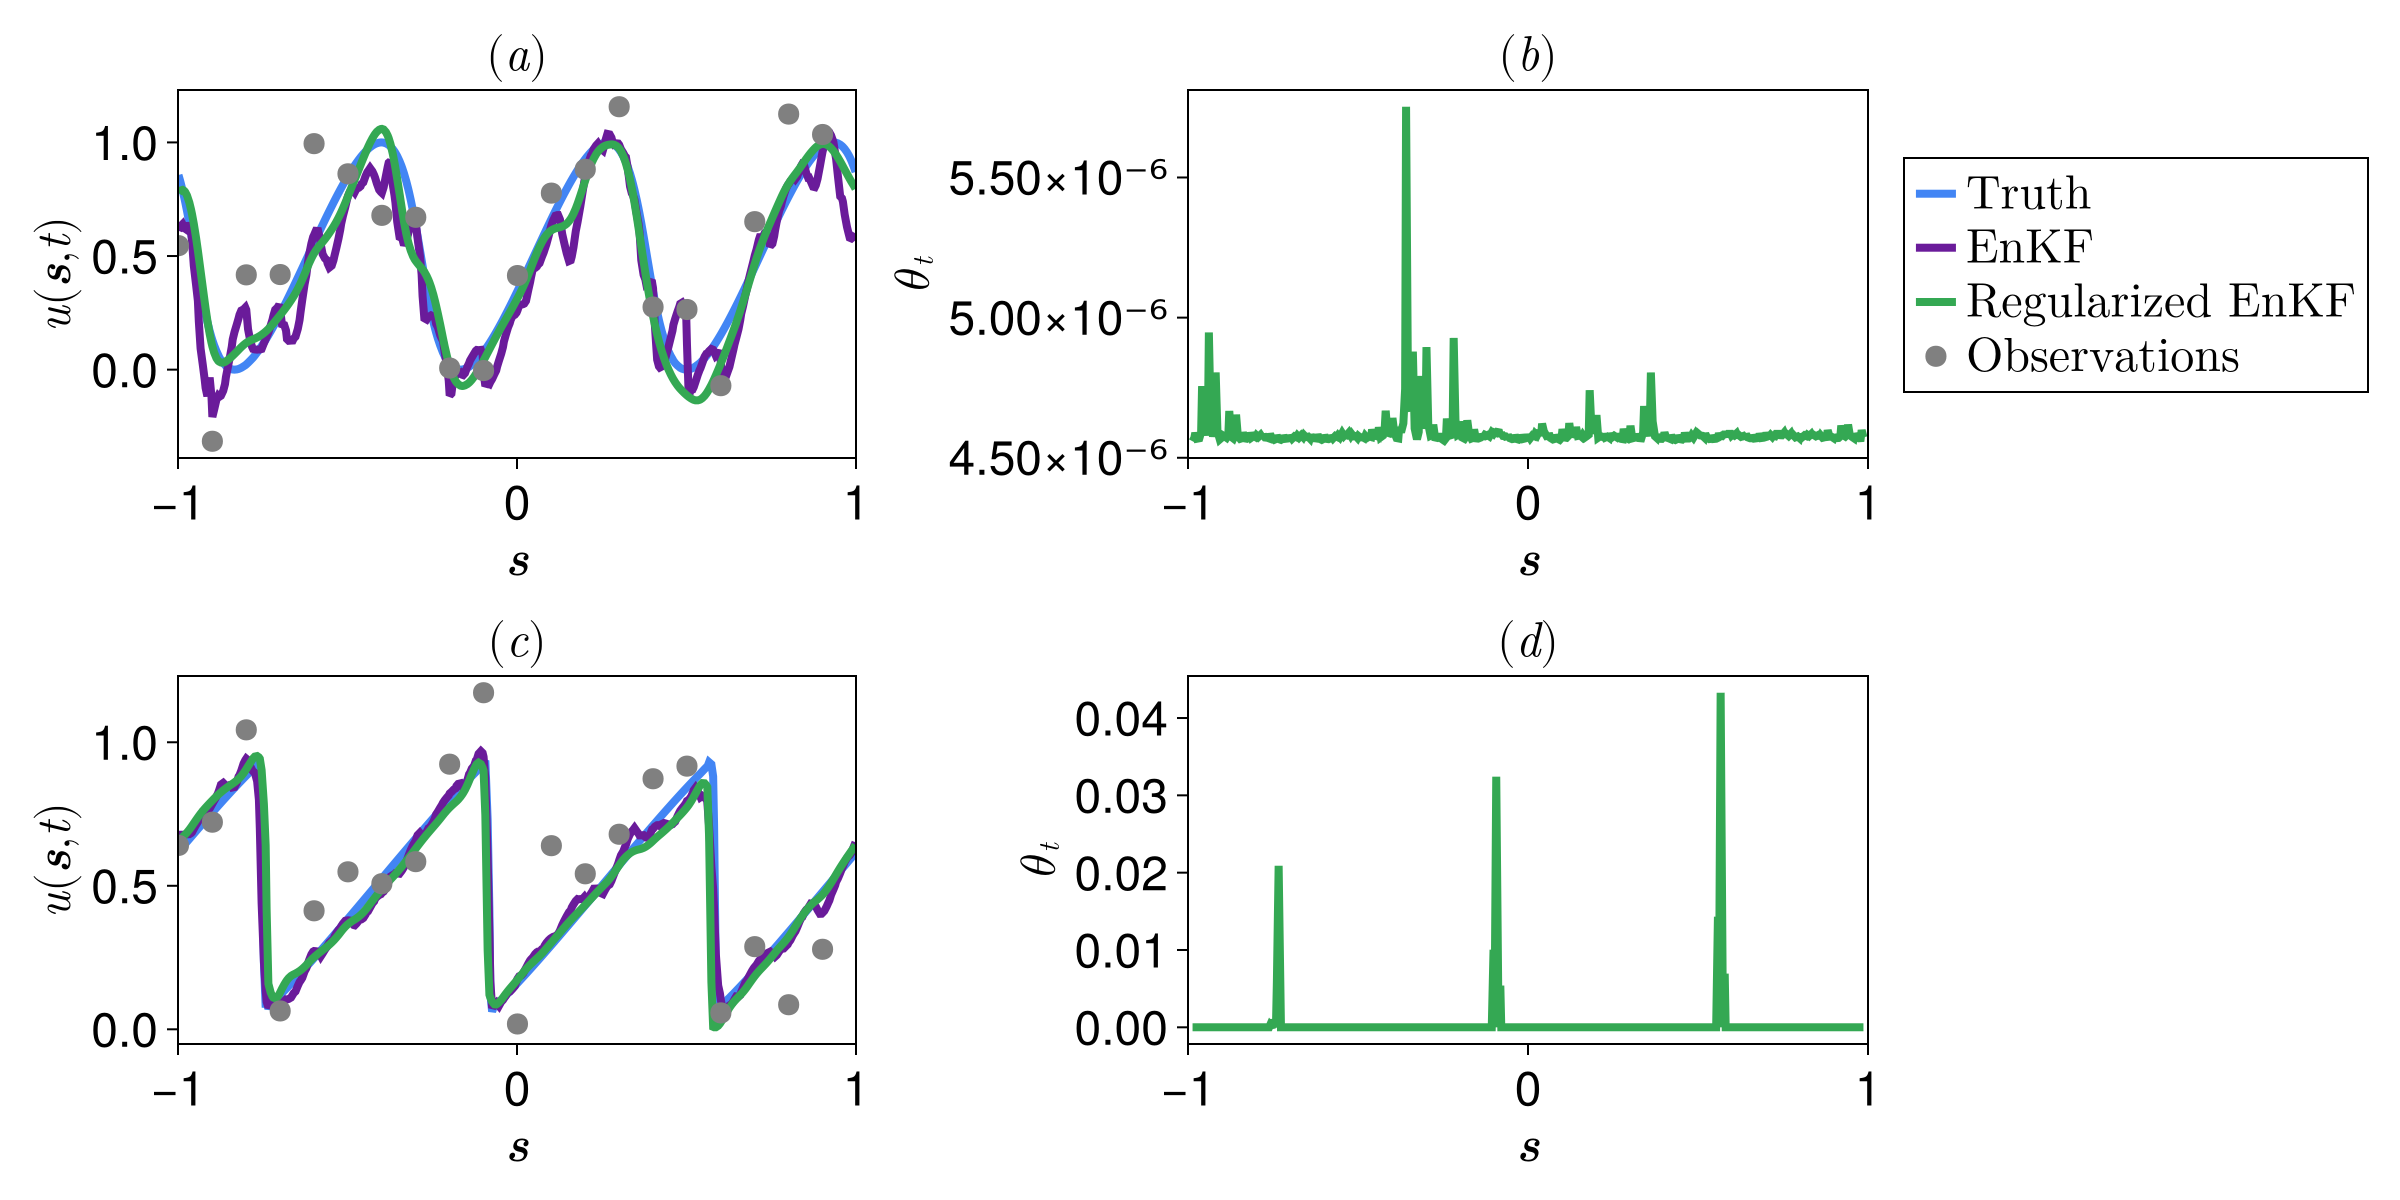

In [66]:
fig = Figure(fontsize = 24, size = (1200, 600))
    
ax11 = Axis(fig[1,1], title = L"(a)", 
          xlabel = L"\mathbf{s}",
          ylabel = L"u(\mathbf{s}, t)",
          xticks = [-1.0; 0.0; 1.0],
          ytickformat = "{:.1f}",
          xgridvisible = false,
          ygridvisible = false)
#           xticklabelformatter = x -> string(round(x, digits=1)),
#           yticklabelformatter = y -> string(round(y, digits=1)))
#           ylabel = L"\boldsym" 

tsnap1 = 10

lines!(ax11, xgrid, data.xt[:,tsnap1], linewidth = 4, label = L"\text{Truth}", color = google_colors[1])
lines!(ax11, xgrid, mean(X_locenkf[tsnap1+1]; dims = 2)[:,1], linewidth = 4, color = google_colors[6],
label = L"\text{EnKF}")



lines!(ax11, xgrid, mean(X_hlocenkf[tsnap1+1]; dims = 2)[:,1], linewidth = 4, label = L"\text{Regularized EnKF}", 
       color = google_colors[4])

scatter!(ax11, xgrid[1:Δ:end], data.yt[:,tsnap1], 
        color = :grey, markersize = 15, label = L"\text{Observations}")


xlims!(ax11, -1, 1)

ax12 = Axis(fig[1,2], title = L"(b)",
          xlabel = L"\mathbf{s}",
          ylabel = L"\mathbf{\theta}_t",
          xticks = [-1.0; 0.0; 1.0],
#           ytickformat = values -> [L"%$(value)" for value in values],
        xgridvisible = false,
        ygridvisible = false,)
#           ylabel = L"\boldsym" 


lines!(ax12, xs, θ_hlocenkf[tsnap1], linewidth = 4, label = L"\mathbf{\theta}", color = google_colors[4])
xlims!(ax12, -1, 1)


    
ax21 = Axis(fig[2,1], title = L"(c)",
          xlabel = L"\mathbf{s}",
          ylabel = L"u(\mathbf{s}, t)",
          xticks = [-1.0; 0.0; 1.0],
# values -> [L"\sqrt{%$(value^2)}
        xgridvisible = false,
        ygridvisible = false,)
#           ylabel = L"\boldsym" 

tsnap2 = 50

lines!(ax21, xgrid, data.xt[:,tsnap2], linewidth = 4, label = L"\text{Truth}", color = google_colors[1])
lines!(ax21, xgrid, mean(X_locenkf[tsnap2+1]; dims = 2)[:,1], linewidth = 4, color = google_colors[6],
label = L"\text{EnKF}")



lines!(ax21, xgrid, mean(X_hlocenkf[tsnap2+1]; dims = 2)[:,1], linewidth = 4, label = L"\text{Regularized EnKF}", 
       color = google_colors[4])

scatter!(ax21, xgrid[1:Δ:end], data.yt[:,tsnap2], 
        color = :grey, markersize = 15, label = L"\text{Observations}")


xlims!(ax21, -1, 1)

ax22 = Axis(fig[2,2], title = L"(d)",
          xlabel = L"\mathbf{s}",
          ylabel = L"\mathbf{\theta}_t",
          xticks = [-1.0; 0.0; 1.0],
        xgridvisible = false,
        ygridvisible = false,)
#           ylabel = L"\boldsym" 

lines!(ax22, xs, θ_hlocenkf[tsnap2], linewidth = 4, label = L"\mathbf{\theta}", color = google_colors[4])
xlims!(ax22, -1, 1)

legend = Legend(fig[1, 3], ax11)

fig

save("profile_burgers.pdf", fig)

fig

In [89]:
mean_hist(X_locenkf)[:,2:end]

400×200 Matrix{Float64}:
 0.649664  0.577097  0.67415   0.821068  …  0.536096  0.53532   0.522868
 0.644766  0.600644  0.645287  0.767743     0.546694  0.541287  0.53224
 0.621231  0.600179  0.641444  0.68412      0.549584  0.546913  0.542783
 0.578561  0.578539  0.625892  0.61693      0.546279  0.5497    0.544841
 0.526967  0.532762  0.58885   0.585248     0.540516  0.549927  0.546402
 0.465706  0.441373  0.509422  0.529856  …  0.526599  0.538626  0.54746
 0.406174  0.355027  0.402723  0.428538     0.511029  0.521342  0.534219
 0.345968  0.28238   0.322595  0.362238     0.497259  0.510656  0.519
 0.29066   0.236379  0.274665  0.32024      0.492808  0.503791  0.513976
 0.241261  0.192842  0.23381   0.2741       0.491611  0.490377  0.501792
 0.208193  0.168832  0.214122  0.251707  …  0.494976  0.491552  0.491967
 0.181938  0.155079  0.201451  0.239947     0.501186  0.497103  0.49221
 0.159104  0.133526  0.193183  0.234502     0.504771  0.496847  0.49274
 ⋮                               

In [91]:
xgrid

400-element Vector{Float64}:
 -0.9986113631159403
 -0.9933998104358487
 -0.9866001895641519
 -0.9813886368840595
 -0.9786113631159403
 -0.9733998104358488
 -0.9666001895641518
 -0.9613886368840595
 -0.9586113631159403
 -0.9533998104358486
 -0.9466001895641517
 -0.9413886368840595
 -0.9386113631159403
  ⋮
  0.9413886368840593
  0.9466001895641516
  0.9533998104358488
  0.9586113631159405
  0.9613886368840594
  0.9666001895641515
  0.973399810435849
  0.9786113631159405
  0.9813886368840595
  0.9866001895641516
  0.9933998104358489
  0.9986113631159406

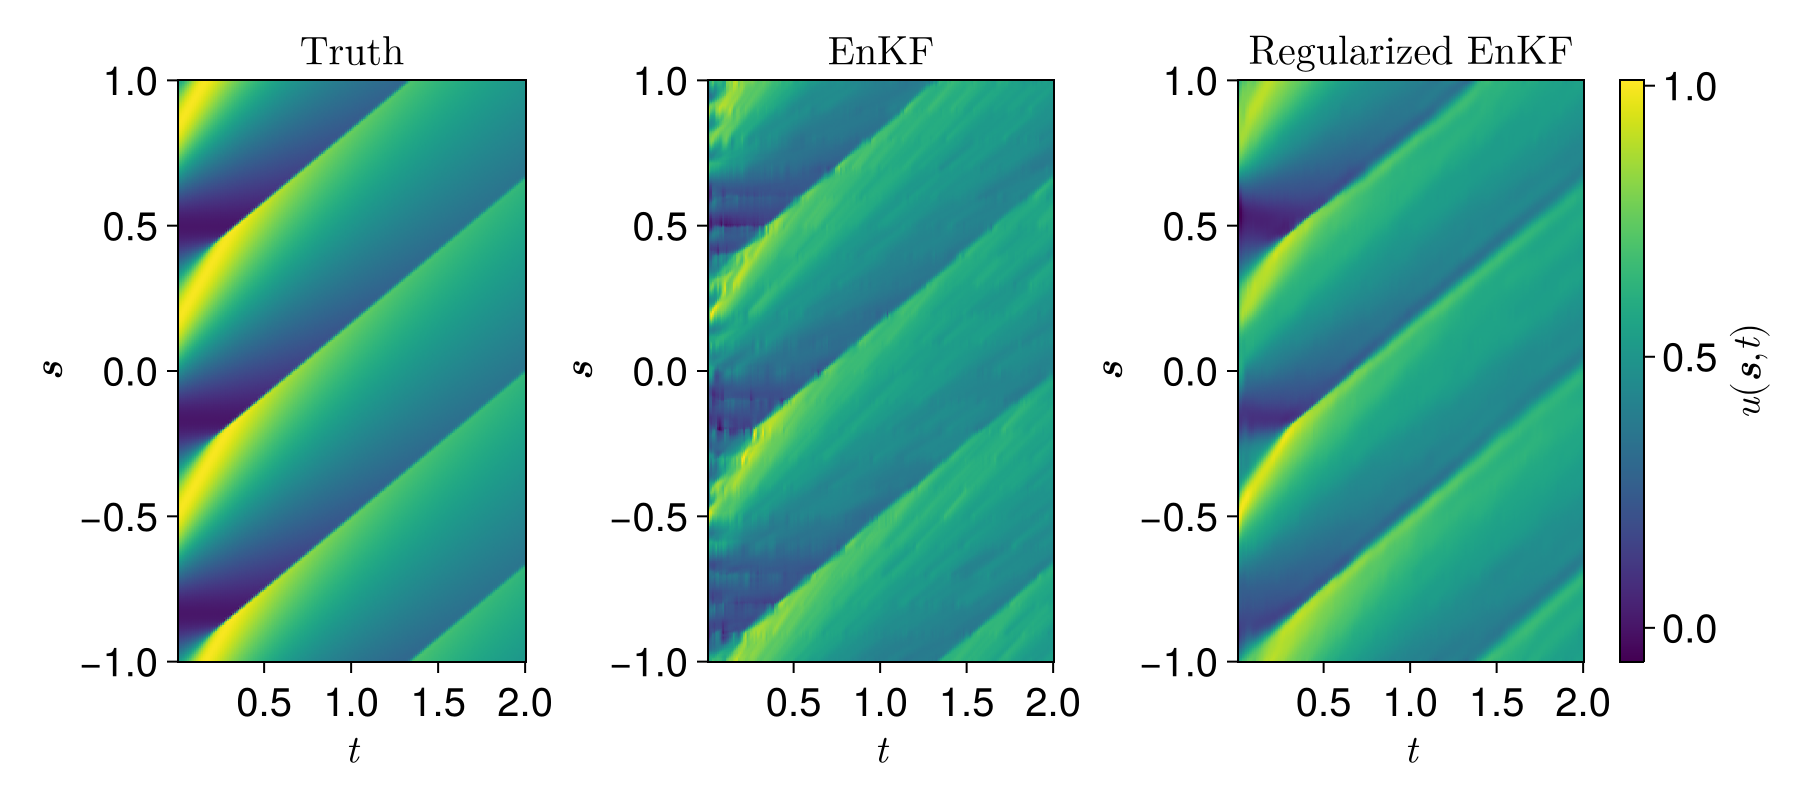

In [126]:
fig = Figure(fontsize = 20, size = (900, 400))


ax1 = Axis(fig[1,1], 
           title = L"\text{Truth}",
           xlabel = L"t",
           ylabel = L"\mathbf{s}",)

h1 = heatmap!(ax1, data.tt, xgrid, data.xt')

Colorbar(fig[1, 4], h1, label = L"u(\mathbf{s}, t)")


ax2 = Axis(fig[1,2], 
           title = L"\text{EnKF}",
           xlabel = L"t",
           ylabel = L"\mathbf{s}",)
h2 = heatmap!(ax2, data.tt, xgrid, mean_hist(X_locenkf)[:,2:end]')


ax3 = Axis(fig[1,3],
           title = L"\text{Regularized EnKF}",
           xlabel = L"t",
           ylabel = L"\mathbf{s}",)
h3 = heatmap!(ax3, data.tt, xgrid, mean_hist(X_hlocenkf)[:,2:end]')


# ax4 = Axis(fig[1,4],
#            title = L"\text{Regularized EnKF}",
#            xlabel = L"t",
#            ylabel = L"\mathbf{s}",)
# h4 = heatmap!(ax4, data.tt, xs, hcat(θ_hlocenkf...)[:,2:end]')

# fig

save("heatmap_inviscid_burgers.pdf", fig)

fig

396×201 Matrix{Float64}:
 4.55992e-6  4.55841e-6  4.55871e-6  …  4.56043e-6  4.56024e-6  4.55992e-6
 4.58239e-6  4.55968e-6  4.5643e-6      4.60506e-6  4.58212e-6  4.58239e-6
 4.59421e-6  4.56551e-6  4.59406e-6     4.64388e-6  4.58863e-6  4.59421e-6
 4.57577e-6  4.56061e-6  4.56692e-6     4.597e-6    4.57536e-6  4.57577e-6
 4.5962e-6   4.55968e-6  4.5627e-6      4.5956e-6   4.59783e-6  4.5962e-6
 4.58325e-6  4.56276e-6  4.57473e-6  …  4.58243e-6  4.58631e-6  4.58325e-6
 4.59581e-6  4.58064e-6  4.65229e-6     4.58365e-6  4.59363e-6  4.59581e-6
 4.58342e-6  4.56395e-6  4.57821e-6     4.57623e-6  4.58481e-6  4.58342e-6
 4.5931e-6   4.56084e-6  4.56604e-6     4.58985e-6  4.59051e-6  4.5931e-6
 4.58274e-6  4.56514e-6  4.57969e-6     4.59156e-6  4.58309e-6  4.58274e-6
 4.5744e-6   4.59229e-6  4.67094e-6  …  4.58121e-6  4.57685e-6  4.5744e-6
 4.58301e-6  4.56559e-6  4.57802e-6     4.58083e-6  4.58148e-6  4.58301e-6
 4.60091e-6  4.56118e-6  4.5644e-6      4.58889e-6  4.59682e-6  4.60091e-6
 ⋮ 

In [ ]:
fig = Figure()


ax = Axis(fig[1,1])

heatmap!(ax, data.xt')

fig

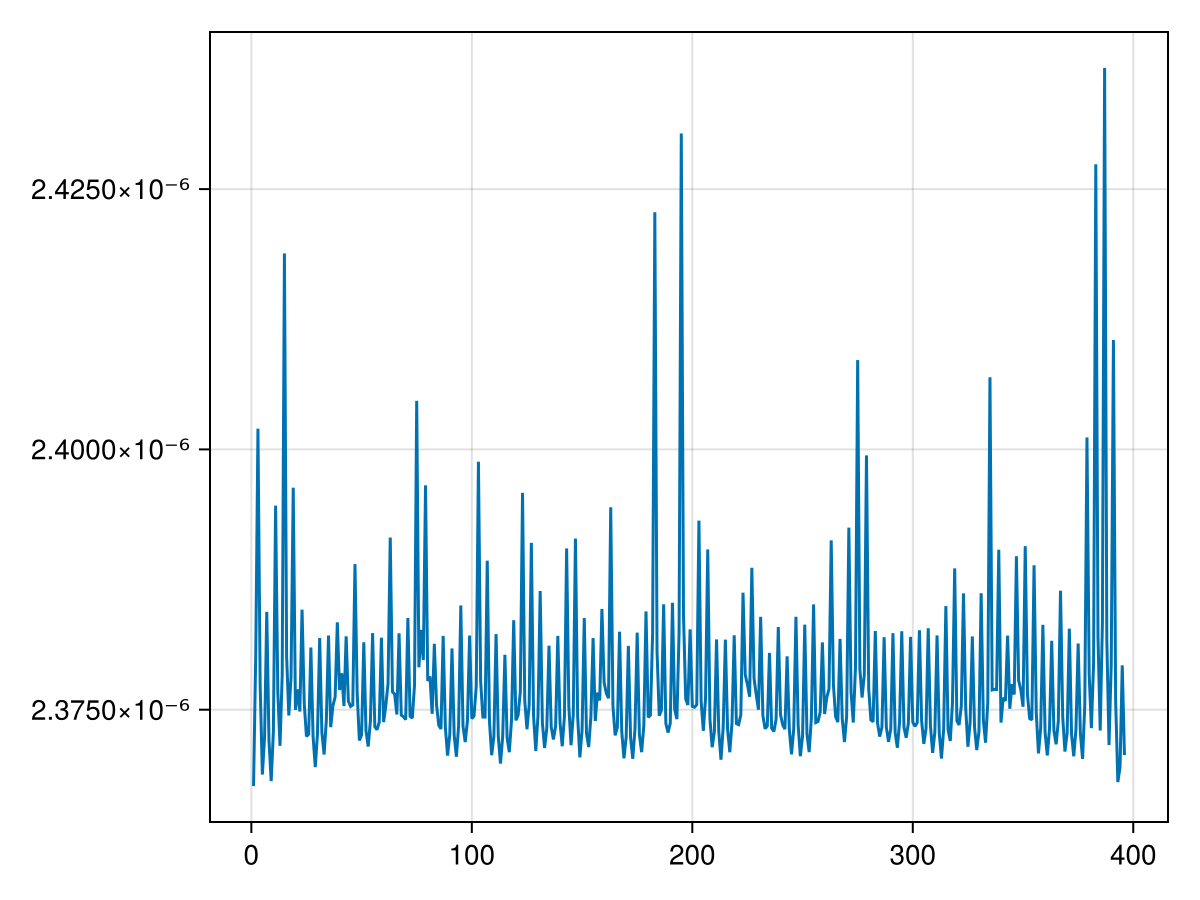

In [131]:
lines(θ_hlocenkf[tsnap])

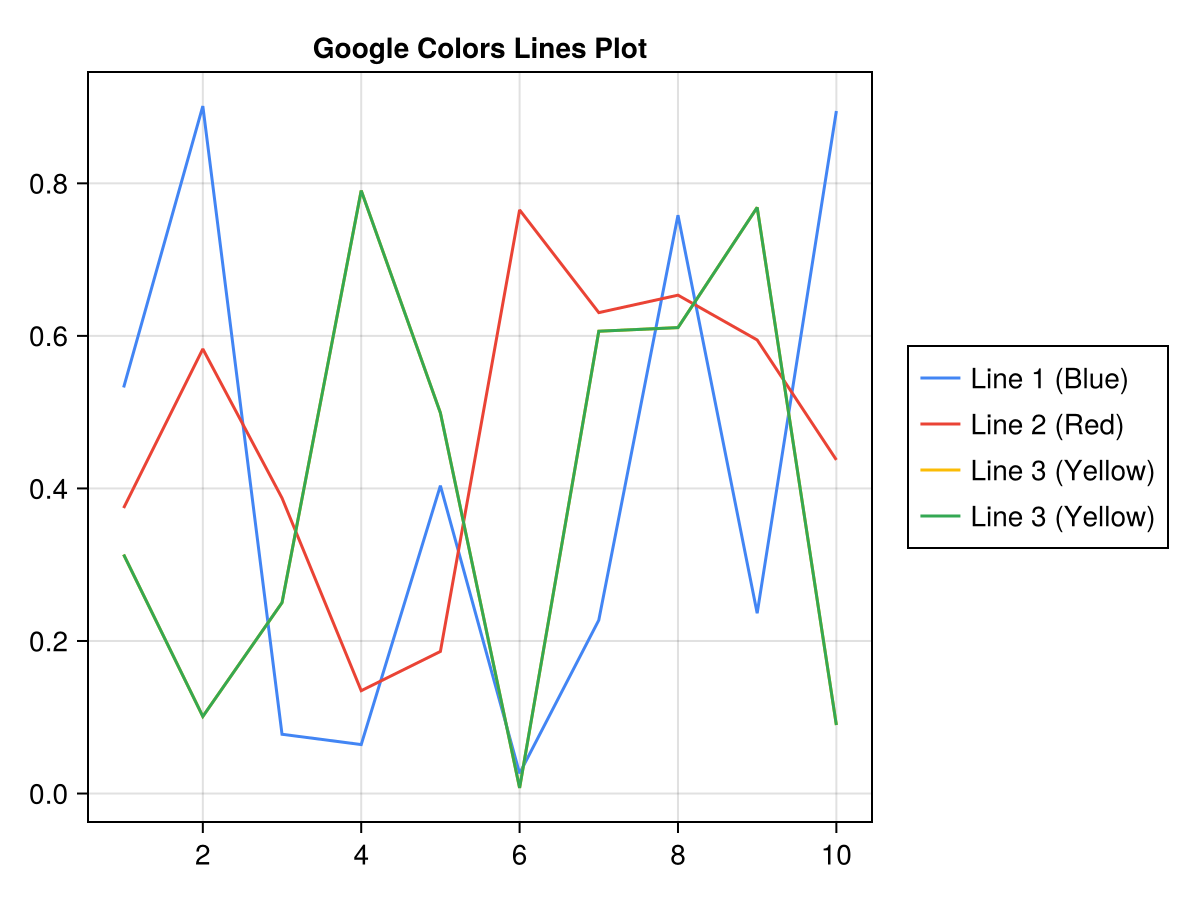

In [48]:
using CairoMakie

# Define the colors
google_colors = [
    RGBf(0.2588, 0.5216, 0.9569),  # Blue: #4285F4
    RGBf(0.9176, 0.2627, 0.2078),  # Red: #EA4335
    RGBf(0.9843, 0.7373, 0.0196),  # Yellow: #FBBC05
    RGBf(0.2039, 0.6588, 0.3255)   # Green: #34A853
]

# Generate some data
x = 1:10
y1 = rand(10)  # Random data for line 1
y2 = rand(10)  # Random data for line 2
y3 = rand(10)  # Random data for line 3

# Create the plot
fig = Figure()
ax = Axis(fig[1, 1], title = "Google Colors Lines Plot")

# Plot each line with a different Google color
lines!(ax, x, y1, color = google_colors[1], label = "Line 1 (Blue)")
lines!(ax, x, y2, color = google_colors[2], label = "Line 2 (Red)")
lines!(ax, x, y3, color = google_colors[3], label = "Line 3 (Yellow)")
lines!(ax, x, y3, color = google_colors[4], label = "Line 3 (Yellow)")


# Add a legend
Legend(fig[1, 2], ax)

# Display the plot
fig


In [153]:
rmse_locenkf = mean(map(i->norm(data.xt[:,i]-mean(X_locenkf[i+1]; dims = 2))/sqrt(Nx), 1:Tf))

0.13273005070254273

In [154]:
spread_locenkf = mean(map(i->spread(X_locenkf[i+1]), 1:Tf))

0.2913554258081962

In [155]:
crps_locenkf = mean(map(i->mean(map(k->CRPS(X_locenkf[i+1][k,:], data.xt[k,i]), 1:Nx)), 1:Tf))

0.07351880182357959

In [156]:
rmse_hlocenkf = mean(map(i->norm(data.xt[:,i]-mean(X_hlocenkf[i+1]; dims = 2))/sqrt(Nx), 1:Tf))

0.04464280382885965

In [157]:
spread_hlocenkf = mean(map(i->spread(X_hlocenkf[i+1]), 1:Tf))

0.019508159289843036

In [158]:
crps_hlocenkf = mean(map(i->mean(map(k->CRPS(X_hlocenkf[i+1][k,:], data.xt[k,i]), 1:Nx)), 1:Tf))

0.021365057428960513

In [159]:
tsnap = Observable(1)

x_tsnap = @lift(hcat(data.x0, data.xt)[:,$(tsnap)])
y_tsnap = @lift(hcat(zeros(Ny), data.yt)[:,$(tsnap)])
X_locenkf_tsnap = @lift(mean(X_locenkf[$tsnap]; dims = 2)[:,1])
X_hlocenkf_tsnap = @lift(mean(X_hlocenkf[$tsnap]; dims = 2)[:,1])

scaled_θ_hlocenkf_tsnap = @lift(θ_hlocenkf[$tsnap] / norm(θ_hlocenkf[$tsnap]))


fig = Figure()

ax1 = Axis(fig[1,1])

lines!(ax1, xgrid, x_tsnap, linewidth = 3, label = "Truth")
lines!(ax1, xgrid, X_locenkf_tsnap, linewidth = 3, label = "LocEnKF")
lines!(ax1, xgrid, X_hlocenkf_tsnap, linewidth = 3, label = "HLocEnKF", linestyle =:dashdot)
scatter!(ax1, xgrid[1:Δ:end], y_tsnap, color = :grey)

axislegend(ax1)

ax2 = Axis(fig[1,2])

lines!(ax2, xs, scaled_θ_hlocenkf_tsnap, linewidth = 3, label = L"θ")
ylims!(ax2, 0.0, 0.6)

framerate = 10
timestamps = range(1, 101, step = 1)

record(fig, "inviscid_burgers.mp4", timestamps; framerate = framerate) do t
    tsnap[] = t
end

"inviscid_burgers.mp4"

In [160]:
time = Observable(0.0)

x1i = @lift(vcat(map(i->sim.u[i]($time)[1], 1:Ne)...))
x2i = @lift(vcat(map(i->sim.u[i]($time)[2], 1:Ne)...))

idx_color_tab = zeros(Int64, Ne)

for i=1:Ne
    x0i = sim.u[i](0.0)
    idx_color_tab[i] = ceil(Int64, phase_coloring(x0i, ColorSchemes.phase))
end


fig, axis, scatterplot = scatter(x1i, x2i, markersize = 20, color = ColorSchemes.phase[idx_color_tab], 
            fontsize = 20, 
            axis = (
            aspect = 1.0,
            title = @lift("t = $(round($time, digits = 1))"),
#             title =  @lift("t = $(time"),
            xlabel = L"x_1", 
            ylabel = L"x_2"))

CairoMakie.xlims!(axis, [-5.0, 5.0])
CairoMakie.ylims!(axis, [-5.0, 5.0])

framerate = 30
timestamps = range(0, tf, step=1/framerate)

record(fig, "spiral2D_animation.mp4", timestamps; framerate = framerate) do t
    time[] = t
end

LoadError: UndefVarError: `sim` not defined

In [ ]:
mean(std(X_hlocenkf[50]; dims = 2))

In [ ]:
mean(std(X_locenkf[50]; dims = 2))

In [ ]:
fig = Figure()

ax = Axis(fig[1,1])

tsnap = 80

# lines!(ax, xs, θ_henkf[tsnap])
lines!(ax, xs, θ_hlocenkf[tsnap])


fig